## Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import glob, os

from langdetect import detect

import emoji
import demoji
demoji.download_codes()

import re

from insta_scraper import InstagramScraper

... OK (Got response in 0.84 seconds)
Writing emoji data to /home/diego/.demoji/codes.json ...
... OK


## Needed Functions

### Transform Emojis to Text

In [2]:
def cleanComments(comments=np.ndarray, emojis="yes"):
    clean_comments = []
    c_len = len(comments)
    
    for i in range(c_len):
        
        if emojis == "yes":
            clean_comment = emoji.demojize(comments[i], delimiters=(" ", ""))
        else:
            clean_comment = demoji.replace(comments[i], repl="")
            
        clean_comment = re.sub(r"_|-", " ", clean_comment)
        clean_comment = re.sub(r"!", "", clean_comment)
        clean_comment = re.sub(r"^([\s\d]+)$", "", clean_comment)
        clean_comment = re.sub(r"\.", "", clean_comment)
        clean_comment = clean_comment.lower()
        clean_comment = clean_comment.strip()
        #clean_comment = "".join([cc for cc in clean_comment if not cc==""])
        
        if clean_comment != "":
            clean_comments.append(clean_comment)
            
    return clean_comments

### Get Only English Comments

In [3]:
def getEnComments(clean_comments):
    
    lan_match = {"clean_comments":clean_comments, "translator":[]}
    
    for c in clean_comments:
        
        try:
            lan_match["translator"].append(detect(c))
        except Exception:
            lan_match["translator"].append("EXCEPTION")
            
    df = pd.DataFrame(lan_match)
    en_comments = list(df["clean_comments"][df.translator=="en"])
    
    return en_comments

### Preprocess

In [4]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

from gensim.models import Phrases
from gensim.models.phrases import Phraser


def preprocess(comments):
    
    tokens = []
    c_len = len(comments)
    
    for i in range(c_len):
        w_tokens = word_tokenize(comments[i])
        alph = [w for w in w_tokens if w.isalpha()]
        lemma = [lemmatizer.lemmatize(a) for a in alph]
        token = [w for w in lemma if w not in stop_words]
        tokens.append(token)
        
    bigram = Phrases(tokens, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = Phrases(bigram[tokens], threshold=100)  
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
    texts = [bigram_mod[doc] for doc in tokens]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    return texts

### Wordcloud

In [5]:
from wordcloud import WordCloud

def get_wordcloud(topic=None, model=None, df=pd.DataFrame, clusters=None):
    
    if model == "LDA":
        wordcloud = WordCloud(width=800, height=560,
                          background_color='black', collocations=False,
                          min_font_size=10).generate(topic)
    else:
        tokens = "".join(list(df.comments[df.clusters==clusters]))
        
        wordcloud = WordCloud(width=800, height=560,
                          background_color='black', collocations=False,
                          min_font_size=10).generate(tokens)
        
    # plot the WordCloud image
    plt.figure(figsize=(15, 7), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f"Cluster Number {clusters}")
    plt.axis("off")
    plt.tight_layout(pad=0)

### Autoenconder

In [6]:
#autoencoders are good for dimensionality reduction, so we will test bert & lda-bert with an autoencoder too
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

def reducAutoencoder(encoding_dim=32, tokens_dim=int, vectors=np.ndarray, epochs=200, batch_size=128):
    
    # This is our input 
    input_ = keras.Input(shape=(tokens_dim,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu')(input_)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(tokens_dim, activation='relu')(encoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_, decoded)
    
    # This model maps an input to its encoded representation
    encoder = keras.Model(input_, encoded)
    
    # This is our encoded (32-dimensional) input
    encoded_input = keras.Input(shape=(encoding_dim,))
    # Retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    X_train, X_test = train_test_split(vectors, test_size=0.25)
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True, 
                    validation_data=(X_test, X_test), verbose=0)
    
    encoded_vecs = encoder.predict(vectors)
    decoded_vecs = decoder.predict(encoded_vecs)
    
    return encoded_vecs, decoded_vecs

### Cluster

In [7]:
#sklearn kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import normalize

def shilouette(x, kmax=20, scale=str): 
    if scale == "yes":
        x = normalize(x, norm='l2')
    sil = []
    klusters = range(2, kmax+1)
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in klusters:
        km = KMeans(n_clusters=k).fit(x)
        labels = km.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))

    plt.plot(klusters, sil, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.title('Silhouette Score Method For Optimal k')
    plt.show()

In [8]:
#tensorflow kmeans
import tensorflow as tf
from tensorflow.python.ops import clustering_ops

SQUARED_EUCLIDEAN_DISTANCE = clustering_ops.SQUARED_EUCLIDEAN_DISTANCE
COSINE_DISTANCE = clustering_ops.COSINE_DISTANCE

def shilouette_tf(vecs, input_fn, kmax=20, distance_m=COSINE_DISTANCE, sil_metric="cosine"): 
    sil = []
    klusters = range(2, kmax+1)
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in klusters:
        km = tf.compat.v1.estimator.experimental.KMeans(num_clusters=k, distance_metric=distance_m, use_mini_batch=False)
        km.train(input_fn)
        labels = [p["cluster_index"] for p in list(km.predict(input_fn))]
        sil.append(silhouette_score(vecs, labels, metric=sil_metric))

    plt.plot(klusters, sil, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.title('Silhouette Score Method For Optimal k')
    plt.show()

In [9]:
#this function will give just the best option from the silhouette score, which sometimes is not a good option
"""def get_silhouette(x, kmax=20): 
    sil = []
    klusters = range(2, kmax+1)
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in klusters:
        km = KMeans(n_clusters=k).fit(x)
        labels = km.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    return max([(e,i) for (e, i) in zip(sil, list(klusters))])[1]"""

"def get_silhouette(x, kmax=20): \n    sil = []\n    klusters = range(2, kmax+1)\n    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2\n    for k in klusters:\n        km = KMeans(n_clusters=k).fit(x)\n        labels = km.labels_\n        sil.append(silhouette_score(x, labels, metric = 'euclidean'))\n    return max([(e,i) for (e, i) in zip(sil, list(klusters))])[1]"

In [10]:
#sklearn kmeans
def clusterK(vecs, k=10, scale=str):
    if scale == "yes":
        vecs = normalize(vecs, norm='l2')
        
    km = KMeans(n_clusters=k).fit(vecs)
    clusters = km.predict(vecs)
        
    return clusters

In [11]:
#tensorflow kmeans
def clusterK_tf(input_fn, k=10, distance_m=COSINE_DISTANCE):
    km = tf.compat.v1.estimator.experimental.KMeans(num_clusters=k, distance_metric=distance_m, use_mini_batch=False)
    km.train(input_fn)
    clusters = [p["cluster_index"] for p in list(km.predict(input_fn))]
    return clusters

In [12]:
from hdbscan import HDBSCAN

def clusterH(vecs=np.ndarray, min_cluster_size=5, min_samples=None, distance_m="euclidean"):
    if distance_m == "euclidean":
        hd = HDBSCAN(min_cluster_size=5, min_samples=None, metric="euclidean")
        clusters = hd.fit(vecs)
    
    elif distance_m == "cosine": 
        norm_data = normalize(vecs, norm='l2')
        hd = HDBSCAN(min_cluster_size=5, min_samples=None, metric="euclidean")
        clusters = hd.fit(norm_data)
        
    return clusters.labels_

### Dimensionality Reduction

In [13]:
from sklearn.preprocessing import StandardScaler

def scaler(x):
    scaler = StandardScaler()

    x_scaled = scaler.fit_transform(x)
    
    return x_scaled

In [14]:
from sklearn.decomposition import PCA

def reducPca(x, n_components=3):
    pca = PCA()
    pca.fit(x)
    print("Top 10 Explained Variance Variables by percentage\n", pca.explained_variance_ratio_[:10],"\n")
    
    #show how well the whole is explained by variance from 0-10 vars
    """plt.figure(figsize=(15,5)) 
    plt.plot(range(1,11), pca.explained_variance_ratio_[:10].cumsum(), marker="o", linestyle="--")
    plt.title("Explained Variance by Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cummulative Explained Variance")"""

    #fit and transform
    pca = PCA(n_components=3).fit(x)
    print("Explained Variance by Percentage with the 3 components selected", pca.explained_variance_ratio_,"\n\n")
    pca_3d = pca.transform(x)
    return pca_3d

In [15]:
from umap import UMAP

def reducUmap(x, n_neighbors=20, n_components=3, metric=str):
    pca_3d = UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric).fit_transform(x)
    return pca_3d

### Concat

In [16]:
def dfConcat(data1=pd.DataFrame, name1=str, data2=pd.DataFrame, name2=str, data3=pd.DataFrame, name3=[]):
    df1 = pd.DataFrame(data1, columns=[name1])
    df2 = pd.DataFrame(data2, columns=[name2])
    df3 = pd.DataFrame(data3, columns=[name3[0], name3[1], name3[2]])    
    df = pd.concat([df1, df2, df3], axis=1)
    print(df.shape)
    print(df.head())
    return df

### Visualize

In [17]:
import plotly.graph_objects as go
import plotly.offline as py

def visualize(df):
    cont = []
    for i in set(df["clusters"]):
        fig = go.Scatter3d(x=df[df["clusters"]==i]['x'],
                            y=df[df["clusters"]==i]['y'],
                            z=df[df["clusters"]==i]['z'],
                            text=df[df["clusters"]==i]['comments'],
                            marker=dict(opacity=0.9,
                                        reversescale=True,
                                        colorscale='Blues',
                                        size=5),
                            line=dict (width=0.02),
                            mode='markers')

        cont.append(fig)    

    #Make Plot.ly Layout
    mylayout = go.Layout(scene=dict(xaxis=dict( title="PCA1"),
                                    yaxis=dict( title="PCA2"),
                                    zaxis=dict(title="PCA3")),)

    #Plot and save html

    py.iplot({"data": cont,
                         "layout": mylayout},
                         filename=("3DPlot.html"))

## Models

### 1. Top2vec

In [18]:
from top2vec import Top2Vec

def showTop2vec(documents=list, search_topic=["girl"], num_topics=5):
    top2vec = Top2Vec(documents=documents, min_count=30, speed="deep-learn", workers=8, verbose=True)
    print("Number of Topics Clustered by Top2vec", top2vec.get_num_topics())
    topic_sizes, topic_nums = top2vec.get_topic_sizes()

    #the wordcloud could be done with the 364 topics, however that is to much and it is better to use the term
    #search_topics to find topics similar to the one selected
    #topic_words, word_scores, topic_nums = model.get_topics(364)

    topic_words, word_scores, topic_scores, topic_nums = top2vec.search_topics(keywords=search_topic, num_topics=num_topics)
    top_topics = [top2vec.generate_topic_wordcloud(topic) for topic in topic_nums]
    print("Top Topics:")
    return top_topics

### 2. LDA

In [19]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

def Lda(tokens=list, n_topics=30):
    dictionary = Dictionary(tokens)
    corpus = [dictionary.doc2bow(text) for text in tokens]
    lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)
    lda_topics = lda.show_topics(formatted=True, num_topics=len(lda.get_topics()))
    print(len(lda_topics))
    return lda_topics

### 3. BERT

In [20]:
from sentence_transformers import SentenceTransformer

def bertVectorize(comments=list):
    bert = SentenceTransformer('bert-base-nli-max-tokens')
    #bert = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
    vec = np.array(bert.encode(comments, show_progress_bar=True))
    print('Getting vector representations for BERT. Done!')
    return vec    

### 4. LDA + BERT

In [21]:
def ldaVectorize(tokens=list, n_topics=30):
    dictionary = Dictionary(tokens)
    corpus = [dictionary.doc2bow(text) for text in tokens]
    lda = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary)
    n_doc = len(corpus)
    vec_lda = np.zeros((n_doc, n_topics))
    for i in range(n_doc):
        # get the distribution for the i-th document in corpus
        for topic, prob in lda.get_document_topics(corpus[i]):
            vec_lda[i, topic] = prob
    
    print('Getting vector representations for LDA. Done!')
    return vec_lda

## Main

Please write a list of hashtags like this: 'premierleague, nba, pga, wimbledon, etc'
Leave it blank if you already have a dataset with comments



Decide typing 'yes' or 'no' whether you want emojis or not
 -- Usually, by including the emojis the may appear a lot in the wordclouds, but the dataset might become much smaller --
no




Please select 1 model among the following:
 -top2vec --it just offer wordcloud, let blank next 3 questions--
 -lda --it just offer wordcloud, let blank next 3 questions--
 -bert
 -lda+bert
bert




Please choose with 'yes' or 'no' if you want autoencoder
Take into account that it is just available with bert or lda+bert
no




Please select 1 clustering method among the following:
 -kmeans
 -hdbscan
Take into account that for kmeans you will give a number clusters, while with hdbscan they are automatically computed
hdbscan




Please select 1 dimensionality reduction method among the following:
 -pca
 -umap
Umap keeps a significant portion of the high-dimens

/home/diego/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)




Getting vector representations for BERT. Done!
For clustering please select between the 'euclidean' or 'cosine' distance
Hint: cosine distance is preferred when texts have different length
cosine
Please write the minimum cluster size you want
Just take into account that usually the bigger the cluster size the less the clusters, so if your dataset is too big, it is better that you take a bigger min_cluster_size
400
----------------------------------------------------------------------------------------------------------
Top 10 Explained Variance Variables by percentage
 [0.16143686 0.08036366 0.06982896 0.04540208 0.03505139 0.02955133
 0.02494061 0.02168662 0.02134992 0.02114637] 

Explained Variance by Percentage with the 3 components selected [0.16143659 0.0803635  0.06982888] 


----------------------------------------------------------------------------------------------------------
(626, 5)
                                            comments  clusters          x  \
0            

----------------------------------------------------------------------------------------------------------
Getting Bert Wordcloud


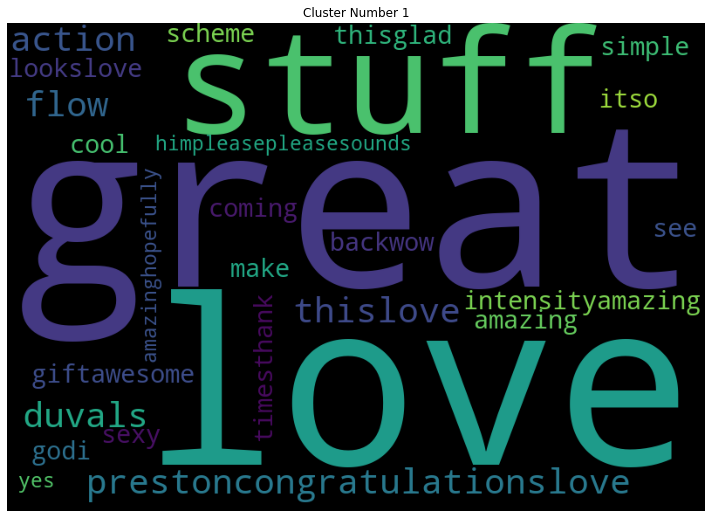

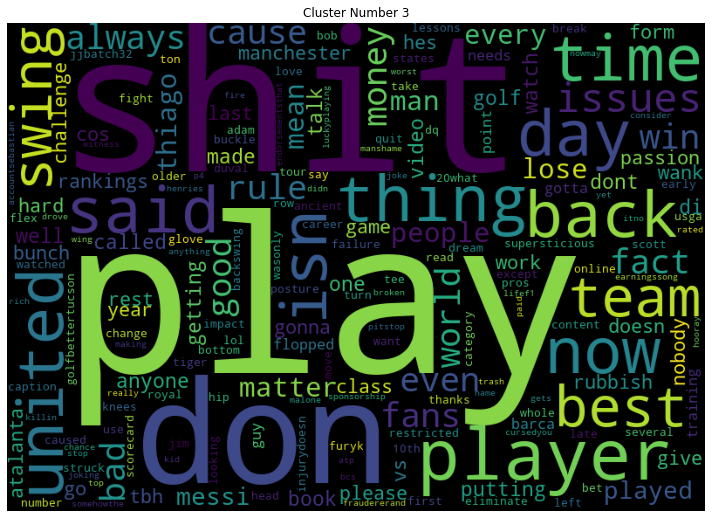

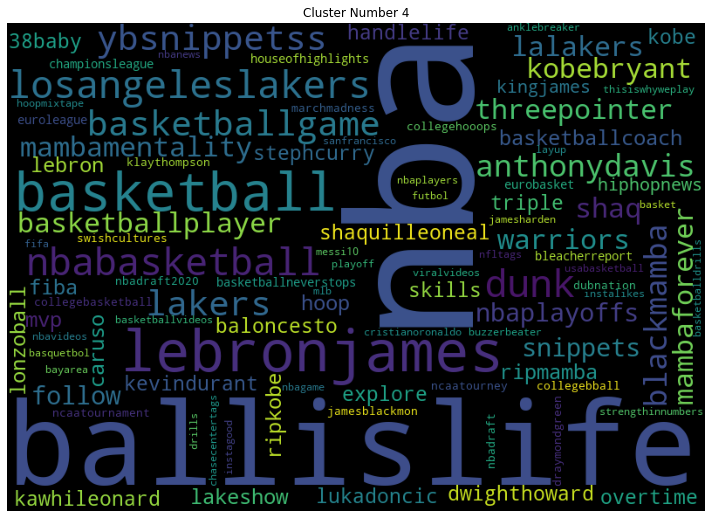

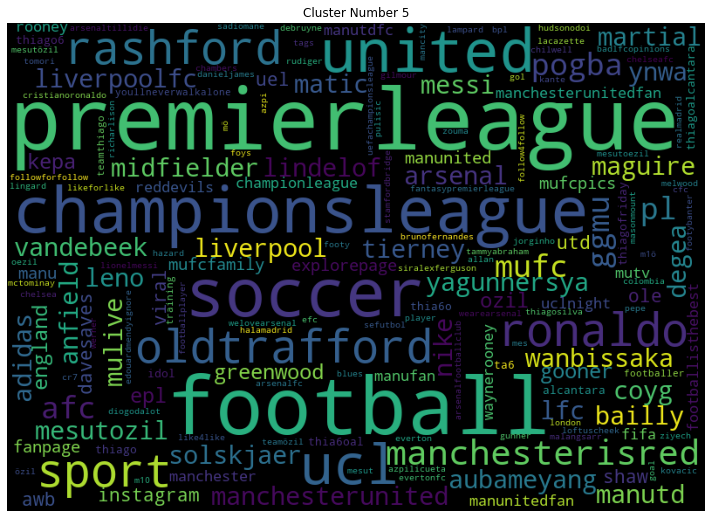

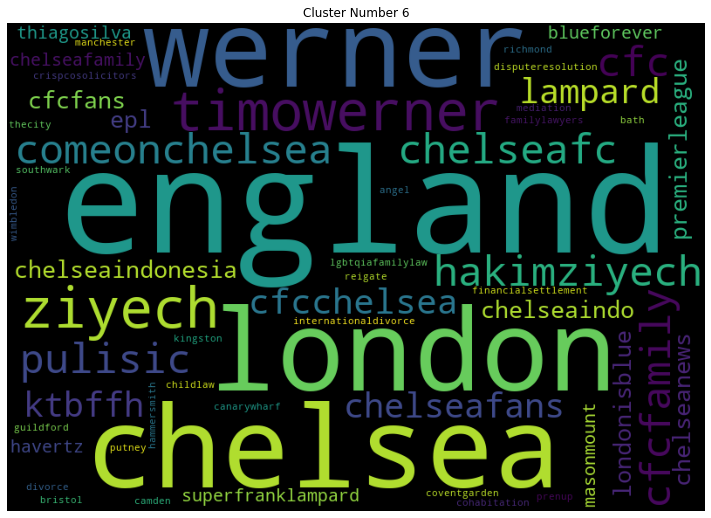

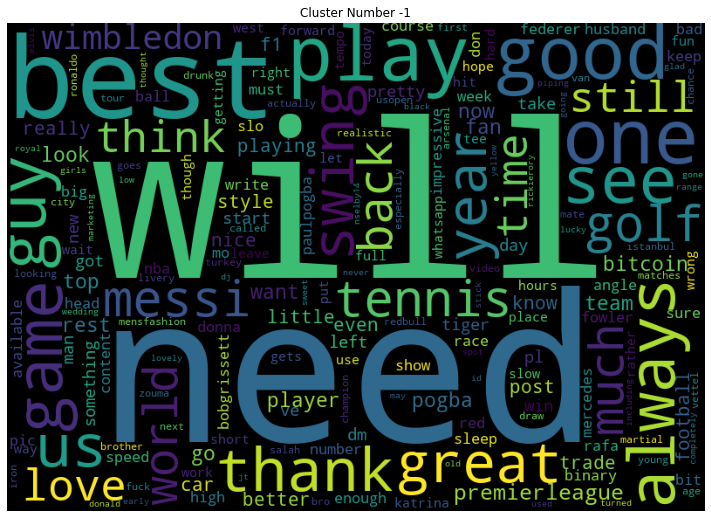

In [22]:
hashtags = list(input("Please write a list of hashtags like this: 'premierleague, nba, pga, wimbledon, etc'\nLeave it blank if you already have a dataset with comments\n").split(", "))
print("\n")

emojis = input("Decide typing 'yes' or 'no' whether you want emojis or not\n -- Usually, by including the emojis the may appear a lot in the wordclouds, but the dataset might become much smaller --\n")
print("\n")
while emojis != "yes" and emojis != "no":
    emojis = input("Please input 'yes' or 'no'\n")   
print("\n")

model = input("Please select 1 model among the following:\n -top2vec --it just offer wordcloud, let blank next 3 questions--\n -lda --it just offer wordcloud, let blank next 3 questions--\n -bert\n -lda+bert\n")
print("\n")
while model != "top2vec" and model != "lda" and model != "bert" and model != "lda+bert":
    model = input("Please input one of the mentioned models\n")   
print("\n")

autoencoder = input("Please choose with 'yes' or 'no' if you want autoencoder\nTake into account that it is just available with bert or lda+bert\n")
print("\n")
while autoencoder != "yes" and autoencoder != "no":
    autoencoder = input("Please input 'yes' or 'no'\n")   
print("\n")

cluster_method = input("Please select 1 clustering method among the following:\n -kmeans\n -hdbscan\nTake into account that for kmeans you will give a number clusters, while with hdbscan they are automatically computed\n")
print("\n")
while cluster_method != "kmeans" and cluster_method != "hdbscan":
    cluster_method = input("Please input one of the mentioned methods\n")   
print("\n")

dim_reduc_method = input("Please select 1 dimensionality reduction method among the following:\n -pca\n -umap\nUmap keeps a significant portion of the high-dimensional local structure in lower dimensionality\n")
print("\n")
while dim_reduc_method != "pca" and dim_reduc_method != "umap":
    dim_reduc_method = input("Please input one of the mentioned methods\n")   
print("\n")

print("----------------------------------------------------------------------------------------------------------")

def main(hashtags=hashtags, emojis=emojis, model=model, autoencoder=autoencoder, cluster_method=cluster_method, dim_reduc_method=dim_reduc_method):
    #if new hastag to add
    if hashtags != ['']:
        insta_scraper = InstagramScraper(hashtags)
        insta_scraper.lookUp(hashtags)
    
    #load all collected comments in one Dataframe
    df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "*.csv"))))
    print("Dataframe shape:", df.shape,"\n")
    print("Dataframe", df.head(),"\n")
    print("Checking for null values..", df.isnull().sum(),"\n")
    print("Deleting nans -->", df.dropna(inplace=True),"\n")
    print("Re-checking for nans -->", df.comments.isnull().sum(),"\n")
    print("----------------------------------------------------------------------------------------------------------")


    #clean and keep english comments
    print("Cleaning comments...")
    clean_comments = cleanComments(df.comments.values, emojis)
    print("Taking only english comments...")
    en_comments = getEnComments(clean_comments)
    
    #from comments to tokens
    print("Getting tokens\n")
    tokens = preprocess(en_comments)
    print("----------------------------------------------------------------------------------------------------------")

    
    #the model chosen will run and create either wordcloud or wordcloud + clusters
    if model == "top2vec":
        #you will have to choose number of topics and the topic related
        search_topic = list(input("Please write a list of topics to show related wordclouds topic, write the list like this: 'child, girl, etc'\nPlease don't leave it blank, choose at least one topic\n").split(", "))
        print("\n")
        num_topics = int(input("Select number of topics:"))
        print("Getting Top2Vec Wordcloud")
        showTop2vec(documents=en_comments, search_topic=search_topic, num_topics=num_topics)
    
    elif model == "lda":
        #lda model uses tokens instead of comments, you can select the number of topics to show in wordcloud
        n_topics = int(input("Select number of topics for Lda:"))
        lda_topics = Lda(tokens=tokens, n_topics=n_topics)
        print("Getting Lda Wordcloud")
        for i in lda_topics:
            #don't change this
            get_wordcloud(i[1], model="LDA")
    
    elif model == "bert" and autoencoder == "no":
        to_use_vecs = bertVectorize(comments=en_comments)
        
        d_metric = input("For clustering please select between the 'euclidean' or 'cosine' distance\nHint: cosine distance is preferred when texts have different length\n")
        while d_metric != "euclidean" and d_metric != "cosine":
            d_metric = input("Please select 1 of the mentioned distances\n")
        
        if cluster_method == "kmeans":
            scale = input("As you selected kMeans, choose to scale data with 'yes' or not scale with 'no':\nhint: scale is recommended with gradient descent algos like lin/log reression or distance algos like kMeans, KNN or SVM\n")
            while scale != "yes" and scale != "no":
                scale = input("Please select 'yes' or 'no'\n")
            #this function will recommend a number of clusters based in the KMeans algorithm
            #the bigger the score the better
            #kmax is the max number of clusters that is usually recommended
            print("----------------------------------------------------------------------------------------------------------")
            print("Getting the Shilouette Score...")   
            if d_metric == "cosine": 
                if scale == "yes":
                    input_vecs = normalize(to_use_vecs, norm='l2')
                elif scale == "no":
                    input_vecs = to_use_vecs
                #input function for tensorflow kmeans
                def input_fn():
                    return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(input_vecs, dtype=tf.float32), num_epochs=1)       
                shilouette_tf(to_use_vecs, input_fn, kmax=20, distance_m=COSINE_DISTANCE, sil_metric="cosine")
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK_tf(input_fn, k, distance_m=COSINE_DISTANCE)       
            elif d_metric == "euclidean":
                shilouette(to_use_vecs, kmax=20, scale=scale)
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK(to_use_vecs, k, scale=scale)         
        else:
            min_cluster_size = int(input("Please write the minimum cluster size you want\nJust take into account that usually the bigger the cluster size the less the clusters, so if your dataset is too big, it is better that you take a bigger min_cluster_size\n"))         
            clusters = clusterH(to_use_vecs, min_cluster_size=min_cluster_size, min_samples=None, distance_m=d_metric)
        #we will use pca algorithm to reduce the dimensions to 3, so we can visualize it
        print("----------------------------------------------------------------------------------------------------------")
        df_scaled = scaler(to_use_vecs)
        
        if dim_reduc_method == "pca":
            pca_3d = reducPca(df_scaled)
        else:
            metric = input("As you selected Umap for dim reduction, please select between the 'euclidean' or 'cosine' distance:\n")
            while metric != "euclidean" and metric != "cosine":
                metric = input("Please select 1 of the mentioned distances\n")
            n_neighbors = int(input("Also, please select the number of neighbors\nTake into account that the smaller the number, the more local the structure will be\nThe recommended range is 15-50\n"))
            pca_3d = reducUmap(df_scaled, n_neighbors=n_neighbors, metric=metric)
        print("----------------------------------------------------------------------------------------------------------")
        df_bert = dfConcat(en_comments, "comments", clusters, "clusters", pca_3d, name3=["x", "y", "z"])
        #finally this will create a 3d visual of the clusters
        print("----------------------------------------------------------------------------------------------------------")
        print("Visualizing Bert Clusters")
        visualize(df_bert)
        #this point will create a wordcloud based in the number of clusters you choosed
        print("----------------------------------------------------------------------------------------------------------")
        print("Getting Bert Wordcloud")
        for i in set(df_bert.clusters):
            get_wordcloud(topic=None, model=None, df=df_bert, clusters=i)
        
    
    elif model == "bert" and autoencoder == "yes":
        bert_vecs = bertVectorize(comments=en_comments)
        #as said before, autoencoders a sometimes a better tool for dimensionality reduc than pca or tsne
        to_use_vecs, dec_vecs = reducAutoencoder(encoding_dim=32, tokens_dim=bert_vecs.shape[1], vectors=bert_vecs, epochs=200, batch_size=128)
        
        d_metric = input("For clustering please select between the 'euclidean' or 'cosine' distance\nHint: cosine distance is preferred when texts have different length\n")
        while d_metric != "euclidean" and d_metric != "cosine":
            d_metric = input("Please select 1 of the mentioned distances\n")
        
        if cluster_method == "kmeans":
            scale = input("As you selected kMeans, choose to scale data with 'yes' or not scale with 'no':\nhint: scale is recommended with gradient descent algos like lin/log reression or distance algos like kMeans, KNN or SVM\n")
            while scale != "yes" and scale != "no":
                scale = input("Please select 'yes' or 'no'\n")
            #this function will recommend a number of clusters based in the KMeans algorithm
            #the bigger the score the better
            #kmax is the max number of clusters that is usually recommended
            print("----------------------------------------------------------------------------------------------------------")
            print("Getting the Shilouette Score...")   
            if d_metric == "cosine": 
                if scale == "yes":
                    input_vecs = normalize(to_use_vecs, norm='l2')
                elif scale == "no":
                    input_vecs = to_use_vecs
                #input function for tensorflow kmeans
                def input_fn():
                    return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(input_vecs, dtype=tf.float32), num_epochs=1)       
                shilouette_tf(to_use_vecs, input_fn, kmax=20, distance_m=COSINE_DISTANCE, sil_metric="cosine")
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK_tf(input_fn, k, distance_m=COSINE_DISTANCE)       
            elif d_metric == "euclidean":
                shilouette(to_use_vecs, kmax=20, scale=scale)
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK(to_use_vecs, k, scale=scale)         
        else:
            min_cluster_size = int(input("Please write the minimum cluster size you want\nJust take into account that usually the bigger the cluster size the less the clusters, so if your dataset is too big, it is better that you take a bigger min_cluster_size\n"))         
            clusters = clusterH(to_use_vecs, min_cluster_size=min_cluster_size, min_samples=None, distance_m=d_metric)
        #we will use pca algorithm to reduce the dimensions to 3, so we can visualize it
        print("----------------------------------------------------------------------------------------------------------")
        df_scaled = scaler(enc_vecs)
        if dim_reduc_method == "pca":
            pca_3d = reducPca(df_scaled)
        else:
            metric = input("As you selected Umap for dim reduction, please select between the 'euclidean' or 'cosine' distance:\n")
            while metric != "euclidean" and metric != "cosine":
                metric = input("Please select 1 of the mentioned distances\n")
            n_neighbors = int(input("Also, please select the number of neighbors\nTake into account that the smaller the number, the more local the structure will be\nThe recommended range is 15-50\n"))
            pca_3d = reducUmap(df_scaled, n_neighbors=n_neighbors, metric=metric)
        print("----------------------------------------------------------------------------------------------------------")
        df_bert = dfConcat(en_comments, "comments", clusters, "clusters", pca_3d, name3=["x", "y", "z"])
        #finally this will create a 3d visual of the clusters
        print("----------------------------------------------------------------------------------------------------------")
        print("Visualizing Bert Clusters with Autoencoder")
        visualize(df_bert)
        #this point will create a wordcloud based in the number of clusters you choosed
        print("----------------------------------------------------------------------------------------------------------")
        print("Getting Bert Wordcloud with Autoencoder")
        for i in set(df_bert.clusters):
            get_wordcloud(topic=None, model=None, df=df_bert, clusters=i)
        
        
    elif model == "lda+bert" and autoencoder == "no":
        #in this case we will use both vecs (lda+bert) and joint them
        bert_vecs = bertVectorize(comments=en_comments)
        lda_vecs = ldaVectorize(tokens=tokens)
        to_use_vecs = np.c_[lda_vecs, bert_vecs]
       
        d_metric = input("For clustering please select between the 'euclidean' or 'cosine' distance\nHint: cosine distance is preferred when texts have different length\n")
        while d_metric != "euclidean" and d_metric != "cosine":
            d_metric = input("Please select 1 of the mentioned distances\n")
        
        if cluster_method == "kmeans":
            scale = input("As you selected kMeans, choose to scale data with 'yes' or not scale with 'no':\nhint: scale is recommended with gradient descent algos like lin/log reression or distance algos like kMeans, KNN or SVM\n")
            while scale != "yes" and scale != "no":
                scale = input("Please select 'yes' or 'no'\n")
            #this function will recommend a number of clusters based in the KMeans algorithm
            #the bigger the score the better
            #kmax is the max number of clusters that is usually recommended
            print("----------------------------------------------------------------------------------------------------------")
            print("Getting the Shilouette Score...")   
            if d_metric == "cosine": 
                if scale == "yes":
                    input_vecs = normalize(to_use_vecs, norm='l2')
                elif scale == "no":
                    input_vecs = to_use_vecs
                #input function for tensorflow kmeans
                def input_fn():
                    return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(input_vecs, dtype=tf.float32), num_epochs=1)       
                shilouette_tf(to_use_vecs, input_fn, kmax=20, distance_m=COSINE_DISTANCE, sil_metric="cosine")
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK_tf(input_fn, k, distance_m=COSINE_DISTANCE)       
            elif d_metric == "euclidean":
                shilouette(to_use_vecs, kmax=20, scale=scale)
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK(to_use_vecs, k, scale=scale)         
        else:
            min_cluster_size = int(input("Please write the minimum cluster size you want\nJust take into account that usually the bigger the cluster size the less the clusters, so if your dataset is too big, it is better that you take a bigger min_cluster_size\n"))         
            clusters = clusterH(to_use_vecs, min_cluster_size=min_cluster_size, min_samples=None, distance_m=d_metric)
        #we will use pca algorithm to reduce the dimensions to 3, so we can visualize it
        print("----------------------------------------------------------------------------------------------------------")
        df_scaled = scaler(lda_bert_vecs)
        if dim_reduc_method == "pca":
            pca_3d = reducPca(df_scaled)
        else:
            metric = input("As you selected Umap for dim reduction, please select between the 'euclidean' or 'cosine' distance:\n")
            while metric != "euclidean" and metric != "cosine":
                metric = input("Please select 1 of the mentioned distances\n")
            n_neighbors = int(input("Also, please select the number of neighbors\nTake into account that the smaller the number, the more local the structure will be\nThe recommended range is 15-50\n"))
            pca_3d = reducUmap(df_scaled, n_neighbors=n_neighbors, metric=metric)
        print("----------------------------------------------------------------------------------------------------------")
        df_lda_bert = dfConcat(en_comments, "comments", clusters, "clusters", pca_3d, name3=["x", "y", "z"])
        #finally this will create a 3d visual of the clusters
        print("----------------------------------------------------------------------------------------------------------")
        print("Visualizing Lda + Bert Clusters")
        visualize(df_lda_bert)
        #this point will create a wordcloud based in the number of clusters you choosed
        print("----------------------------------------------------------------------------------------------------------")
        print("Getting Lda + Bert Wordcloud")
        for i in set(df_lda_bert.clusters):
            get_wordcloud(topic=None, model=None, df=df_lda_bert, clusters=i)
       
        
    elif model == "lda+bert" and autoencoder == "yes":
        #in this case we will use both vecs (lda+bert) and joint them
        bert_vecs = bertVectorize(comments=en_comments)
        lda_vecs = ldaVectorize(tokens=tokens)
        lda_bert_vecs = np.c_[lda_vecs, bert_vecs]
        #as said before, autoencoders a sometimes a better tool for dimensionality reduc than pca or tsne
        to_use_vecs, dec_vecs = reducAutoencoder(encoding_dim=32, tokens_dim=lda_bert_vecs.shape[1], vectors=lda_bert_vecs, epochs=200, batch_size=128)
        
        d_metric = input("For clustering please select between the 'euclidean' or 'cosine' distance\nHint: cosine distance is preferred when texts have different length\n")
        while d_metric != "euclidean" and d_metric != "cosine":
            d_metric = input("Please select 1 of the mentioned distances\n")
        
        if cluster_method == "kmeans":
            scale = input("As you selected kMeans, choose to scale data with 'yes' or not scale with 'no':\nhint: scale is recommended with gradient descent algos like lin/log reression or distance algos like kMeans, KNN or SVM\n")
            while scale != "yes" and scale != "no":
                scale = input("Please select 'yes' or 'no'\n")
            #this function will recommend a number of clusters based in the KMeans algorithm
            #the bigger the score the better
            #kmax is the max number of clusters that is usually recommended
            print("----------------------------------------------------------------------------------------------------------")
            print("Getting the Shilouette Score...")   
            if d_metric == "cosine": 
                if scale == "yes":
                    input_vecs = normalize(to_use_vecs, norm='l2')
                elif scale == "no":
                    input_vecs = to_use_vecs
                #input function for tensorflow kmeans
                def input_fn():
                    return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(input_vecs, dtype=tf.float32), num_epochs=1)       
                shilouette_tf(to_use_vecs, input_fn, kmax=20, distance_m=COSINE_DISTANCE, sil_metric="cosine")
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK_tf(input_fn, k, distance_m=COSINE_DISTANCE)       
            elif d_metric == "euclidean":
                shilouette(to_use_vecs, kmax=20, scale=scale)
                print("----------------------------------------------------------------------------------------------------------")
                k = int(input("Please write the number of clusters you want: "))
                #this function will create clusters with KMeans algorithm
                clusters = clusterK(to_use_vecs, k, scale=scale)         
        else:
            min_cluster_size = int(input("Please write the minimum cluster size you want\nJust take into account that usually the bigger the cluster size the less the clusters, so if your dataset is too big, it is better that you take a bigger min_cluster_size\n"))         
            clusters = clusterH(to_use_vecs, min_cluster_size=min_cluster_size, min_samples=None, distance_m=d_metric)
        #we will use pca algorithm to reduce the dimensions to 3, so we can visualize it
        print("----------------------------------------------------------------------------------------------------------")
        df_scaled = scaler(enc_vecs)
        if dim_reduc_method == "pca":
            pca_3d = reducPca(df_scaled)
        else:
            metric = input("As you selected Umap for dim reduction, please select between the 'euclidean' or 'cosine' distance:\n")
            while metric != "euclidean" and metric != "cosine":
                metric = input("Please select 1 of the mentioned distances\n")
            n_neighbors = int(input("Also, please select the number of neighbors\nTake into account that the smaller the number, the more local the structure will be\nThe recommended range is 15-50\n"))
            pca_3d = reducUmap(df_scaled, n_neighbors=n_neighbors, metric=metric)
        print("----------------------------------------------------------------------------------------------------------")
        df_lda_bert = dfConcat(en_comments, "comments", clusters, "clusters", pca_3d, name3=["x", "y", "z"])
        #finally this will create a 3d visual of the clusters
        print("----------------------------------------------------------------------------------------------------------")
        print("Visualizing Lda + Bert Clusters with Autoencoder")
        visualize(df_lda_bert)
        #this point will create a wordcloud based in the number of clusters you choosed
        print("----------------------------------------------------------------------------------------------------------")
        print("Getting Lda + Bert Wordcloud with Autoencoder")
        for i in set(df_lda_bert.clusters):
            get_wordcloud(topic=None, model=None, df=df_lda_bert, clusters=i)
        
        
main()